## Load data

In [ ]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras

In [ ]:
%pylab inline
%load_ext autoreload
%autoreload 2

In [ ]:
datapath = '/media/sf_VBox_Shared/timeseries/PAMAP2_Dataset/slidingwindow512cleaned/'
outputpath = '/media/sf_VBox_Shared/timeseries/results/modelshistory.json'

In [ ]:
ext = '.npy'
X_train = np.load(datapath+'X_train'+ext)
y_train_binary = np.load(datapath+'y_train_binary'+ext)
X_val = np.load(datapath+'X_val'+ext)
y_val_binary = np.load(datapath+'y_val_binary'+ext)
X_test = np.load(datapath+'X_test'+ext)
y_test_binary = np.load(datapath+'y_test_binary'+ext)

In [ ]:
num_classes = y_train_binary.shape[1]
print(num_classes)

## Generate models

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam

In [ ]:
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))

from mcfly import modelgen, find_architecture

In [ ]:
models_smalllayer = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 10,
                                  model_type = 'CNN',
                                  cnn_min_fc_nodes=10, cnn_max_fc_nodes=50
                                 )
models_biglayer = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 10,
                                  model_type = 'CNN',
                                  cnn_min_fc_nodes=500, cnn_max_fc_nodes=2000
                                 )
models = models_smalllayer + models_biglayer

## Compare models

In [ ]:
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=10,
                                                                                  subset_size=500,
                                                                                  verbose=True,
                                                                                 outputfile=outputpath)

In [ ]:
%%time
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)

In [23]:
import json
with open(outputpath, 'r') as outfile:
    modelresults = json.load(outfile)
#modelresults = modelresults[20:]

In [24]:
import pandas as pd
val_acc = [m['val_acc'][-1] for m in modelresults]
fc_hidden_nodes = [m['fc_hidden_nodes'] for m in modelresults]
nr_epochs = [len(m['val_acc']) for m in modelresults]
results = pd.DataFrame({'val_acc':val_acc, 'fc_nodes':fc_hidden_nodes, 'nr_epochs':nr_epochs})
results

,fc_nodes,nr_epochs,val_acc
0,11,5,0.706527
1,32,5,0.795715
2,49,5,0.828102
3,50,5,0.752367
4,17,5,0.872945
5,37,5,0.695067
6,20,5,0.856502
7,18,5,0.815147
8,36,5,0.134529
9,34,5,0.005979


In [ ]:
import pandas as pd
results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                        'fc_nodes':[str(params['fc_hidden_nodes']) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

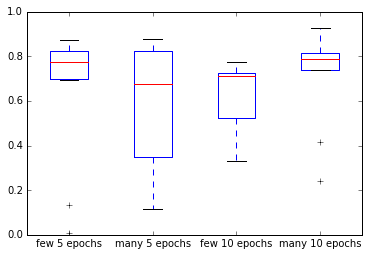

In [25]:
plt.boxplot([results['val_acc'][:10], results['val_acc'][10:20], 
            results['val_acc'][20:30], results['val_acc'][30:]],
           labels=['few 5 epochs', 'many 5 epochs', 'few 10 epochs', 'many 10 epochs'])
plt.show()

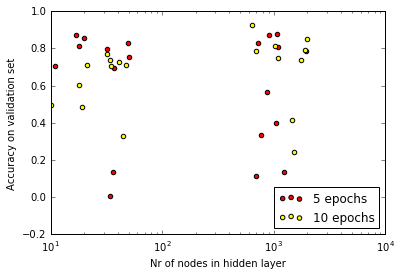

In [37]:
ax = plt.gca()
ax.scatter(results['fc_nodes'][:20], results['val_acc'][:20], c='red', edgecolors=None, label='5 epochs')
ax.scatter(results['fc_nodes'][20:], results['val_acc'][20:], c='yellow', edgecolors=None, label='10 epochs')
plt.xlabel('Nr of nodes in hidden layer')
plt.ylabel('Accuracy on validation set')
plt.legend(loc=4)
ax.set_xscale('log')